# Toy example

**Goal:** Get a basic (toy) example setup that will be easy to adapt for Sara's inputs


**Table of Contents**

1. Toy data setup
2. (Basic) [slot attention](https://arxiv.org/abs/2006.15055) architecture
3. Using xformers [TSPN](https://arxiv.org/abs/2006.16841) instead of GRU, as done in the [global PFlow](htts://arxiv.org/pdf/2212.01328.pdf) work


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time

import collections
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import logging

# The slot attn code
import os
os.sys.path.append('../google-research')

import slot_attention.data as data_utils
import slot_attention.model as model_utils
import slot_attention.utils as utils

from slot_attention.set_prediction.train import train_step

%load_ext autoreload
%autoreload 2

I had a wierd error intermittent depending on when I  [post](https://github.com/tensorflow/tensorflow/issues/43174).

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 1. Toy data setup

Let's start trying to predict the positions of Gaussian blobs!

In [3]:
nTrain = 10000
nPhotons=2

# for paper results -- using (128, 128) img
resolution = (9,9) # for Sara's example, want a (9,9) 

In [4]:
def generateData(nExamples, nPhotons, resolution,
                 range_gen=(-2,2)):
                 
    '''
    Inputs: TO FILL IN LATER
    '''

    # Setup
    nCoords = 2 # (x,y) and the E
    
    
    '''
    Step 1: draw positions for the photon coordinate
    `C`:
    - C[i,0] is the (x,y) location of the first "photon" in event i 
    - C[i,1] is the (x,y) location of the second "photon" in event i
    
    Consider photon energies uniformly distributed from 5 -- 500 GeV
    '''
    C = np.random.uniform(*range_gen,size=(nExamples,nPhotons,1,nCoords)) # coords
    E = np.random.uniform(5,500,size=(nExamples, nPhotons,1)) # energies
    
    Y = np.concatenate([C.squeeze(),E],axis=-1)
    
    '''
    Step 2: Simulate the calorimeter images for each of these photon clusters
    '''
    X_photons   = [[] for i in range (nPhotons) ]
    stop_viz = 16
    
    # Calorimeter images, energy deposited in each cell
    imgs = np.zeros((nExamples, *resolution, 1)) # Shape (nExamples, 9, 9, 1) 
    
    for i, (Es) in enumerate(E.squeeze()):

        Xi = []
        
        for j, E_photon in enumerate(Es): 
        
            # Very simple model, lets assume there's 1 photon produced per GeV of energy.
            nSamples=int(E_photon)
            x_j = C[i,j] + np.random.randn(nSamples, nCoords)
        
            Xi.append(x_j) # Append to get the calo img for this event
            
            if i < stop_viz:
                X_photons[j].append(x_j.squeeze()) # Append to make scatter plots
            
        # Concatenate the calorimeter image from all of these photons
        Xi = np.concatenate(Xi, axis=0)
        
        # Get the histgram image
        imgs[i] = np.histogram2d(*Xi.T, resolution, [(-4.5,4.5),(-4.5,4.5)])[0].reshape(1,*resolution,1) 
        
    return imgs, Y, X_photons
    

In [5]:
X, Y, X_photons = generateData(nTrain,nPhotons=nPhotons,resolution=resolution)

In [6]:
Y.shape # nTrain, # photons, (x,y,E)

(10000, 2, 3)

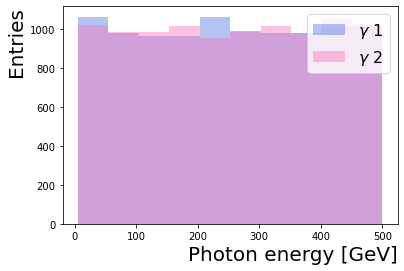

In [7]:
'''
Plot the energy
'''
E = Y[:,:,-1]

plt.hist(E[:,0],color='royalblue',alpha=0.4,label='$\gamma$ 1')
plt.hist(E[:,1],color='hotpink',alpha=0.4,label='$\gamma$ 2')

plt.xlabel('Photon energy [GeV]',fontsize=20,loc='right')
plt.ylabel('Entries',fontsize=20,loc='top')
plt.legend(fontsize=16)
plt.show()

For the regression targets, concat the coords and E

Let's also plot the photons that get produced

In [8]:
# Get the coordinates from the targets
C = Y[:,:,:2]

In [9]:
X_photons[0][1].shape # photon 0, event 1

(326, 2)

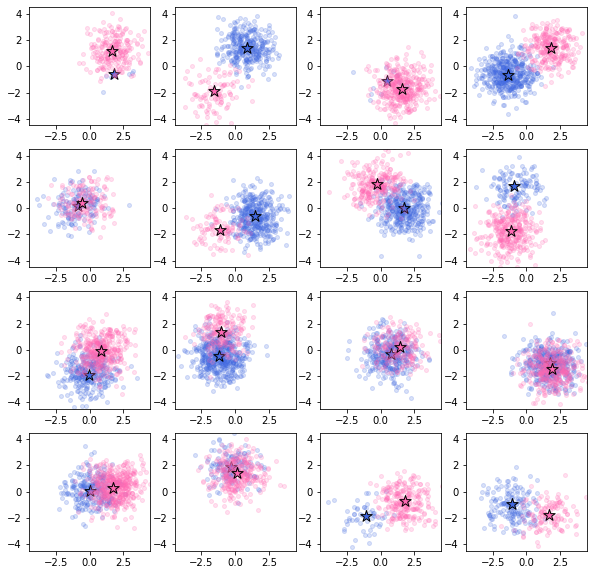

In [10]:
fig, ax = plt.subplots(4,4, figsize=(10,10))

for k in range(16):
    
    i = k // 4
    j = k % 4
    
    axi = ax[i,j]
    
    for i,color_i in zip([0,1],['royalblue','hotpink']):
        
        Xi = X_photons[i][k] # sig from photon 1, event k
        
        axi.scatter(*Xi.T,16,color=color_i,alpha=0.2)
        axi.scatter(*C[k,i].T, 144, marker="*",color=color_i, edgecolor='k')
    
    axi.set_xlim(-4.5,4.5)
    axi.set_ylim(-4.5,4.5)
    
plt.show()   

OK, cool beans, this looks like a cute toy problem :) 

**Possible follow-ups**
- Let the energy be a function of the radius.

Let's make another event display of what the ML inputs look like!

(Discretized showers and not having a color coding for the shower deposits.)

In [11]:
ex = np.linspace(-4.5,4.5,resolution[0]+1)
xx=0.5 * (ex[1:] + ex[:-1])

Xi,Yi = np.meshgrid(xx,xx)
Xi = Xi.flatten()
Yi = Yi.flatten()

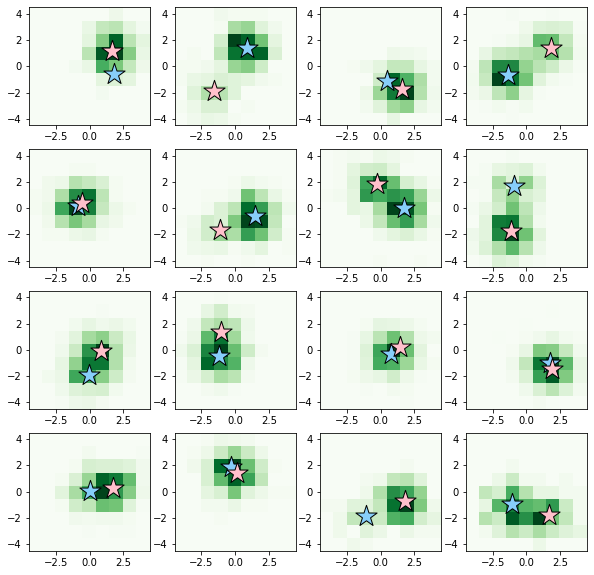

In [12]:
fig, ax = plt.subplots(4,4, figsize=(10,10))

for k in range(16):
    
    i = k // 4
    j = k % 4
    
    axi = ax[i,j]
    
    # Draw the shower
    axi.hist2d(Xi,Yi, resolution, [(-4.5,4.5),(-4.5,4.5)], weights=X[k].T.flatten(),cmap='Greens')
    
    # Draw the truth labels on the plot
    for i,color_i in enumerate(['lightskyblue','pink']):
        axi.scatter(*C[k,i].T, 500, marker="*",color=color_i, edgecolor='k')
        
plt.show()   

In [13]:
'''
Test data (for eval loss + networks)
'''

nTest = 1000 
X_te, Y_te, _ = generateData(nTest,nPhotons=nPhotons,resolution=resolution)

In [14]:
print('Y_te',Y_te.shape)
print('X_te',X_te.shape)


Y_te (1000, 2, 3)
X_te (1000, 9, 9, 1)


## 2. Slot attention (from paper)

Recommendation from Lukas: Don't try to start from scratch... just use the existing implementation :)

Below is just copying some code from `train.py`

In [15]:
# Set up some of the parameters from the flags
model_dir = '/tmp/set_prediction/'

batch_size = 512 
num_slots = 3 # for detecting 2 photons, plus letting one of the outputs focus on the bkg pixels
num_iterations = 3 # 3 steps of slot attention
base_learning_rate = 0.0004
num_train_steps = 1000 # altho longer, 150000 from paper code
warmup_steps = 200
decay_rate = 0.5
decay_steps = 50000

tf.random.set_seed(0)

In [16]:
optimizer = tf.keras.optimizers.Adam(base_learning_rate, epsilon=1e-08)

In [17]:
model = model_utils.build_model(resolution, 
                                batch_size, 
                                num_slots=num_slots,
                                num_iterations=num_iterations, 
                                num_channels=1,
                                model_type="sara_model")

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 9, 9, 1)]          0         
_________________________________________________________________
slot_attention_sara (SlotAtt (512, 3, 3)               78435     
Total params: 78,435
Trainable params: 78,435
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Prepare checkpoint manager.
global_step = tf.Variable(
  0, trainable=False, name="global_step", dtype=tf.int64)

ckpt = tf.train.Checkpoint(
  network=model, optimizer=optimizer, global_step=global_step)

ckpt_manager = tf.train.CheckpointManager(
  checkpoint=ckpt, directory=model_dir, max_to_keep=5)

ckpt.restore(ckpt_manager.latest_checkpoint)

if ckpt_manager.latest_checkpoint:
    logging.info("Restored from %s", ckpt_manager.latest_checkpoint)
else:
    logging.info("Initializing from scratch.")

### Do the preprocessing

In [20]:
def preprocess(X,Y,scalingDict=None):
    '''
    Gaol: given input images and target properties,
    1) Take the log of the energies
    2) Subtract off the mean and divide by the std dev
    
    Inputs: 
    - X: input images
    - Y: Target energies
    - scalingDict
    
    Outputs:
    - X_norm
    - Y_norm
    
    '''
    
    # Step 1: Make copies of the array
    X_norm = np.zeros(X.shape)
    Y_norm = Y.copy()
    
    # Step 2: Take logs of the energy
    mask = (X != 0)
    X_norm[mask] = np.log(X[mask])

    Y_norm[:,:,-1] = np.log(Y_norm[:,:,-1])
    
    # Step 3: Preprocessing -- calc
    if scalingDict is None:
        mu_x = np.mean(X_norm[mask])
        mu_y = np.mean(Y_norm,axis=(0,1),keepdims=True) # shape (1,1,3)

        std_x = np.std(X_norm[mask])
        std_y = np.std(Y_norm,axis=(0,1),keepdims=True) # shape (1,1,3)


        # Save the dictionary
        scalingDict = {
                    "mu_x" :mu_x,
                    "mu_y" :mu_y,
                    "std_x":std_x,
                    "std_y":std_y
                }
    else:
        mu_x = scalingDict["mu_x"]
        mu_y = scalingDict["mu_y"]
        
        std_x = scalingDict["std_x"]
        std_y = scalingDict["std_y"]
        
    X_norm[mask] = (X_norm[mask] - mu_x) / std_x
    Y_norm = (Y_norm - mu_y) / std_y
    
    # Set the zeros of the cell energies to be a bit smaller than the minimimum energy
    X_norm[~mask] = X_norm[mask].min() - 0.5

    
    return X_norm, Y_norm, scalingDict
    

In [21]:
# Apply the preprocessing
X_norm, Y_norm, scalingDict  = preprocess(X,Y)
X_norm_te, Y_norm_te,_ = preprocess(X_te, Y_te, scalingDict)

In [22]:
scalingDict

{'mu_x': 1.8085056467473524,
 'mu_y': array([[[0.01409209, 0.01060071, 5.25772962]]]),
 'std_x': 1.2952760571676134,
 'std_y': array([[[1.15863376, 1.15731571, 0.89579319]]])}

In [23]:
# Make the test data tf tensors
X_test = tf.convert_to_tensor(X_norm_te, dtype=tf.float32) # nTrain, 9, 9
Y_test = tf.convert_to_tensor(Y_norm_te, dtype=tf.float32) # nTrain, 2, 2

print(X_test.shape,Y_test.shape)

(1000, 9, 9, 1) (1000, 2, 3)


In [24]:
import tensorflow.keras.layers as layers

In [25]:
encoder_cnn = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu"),
        layers.Conv2D(64, kernel_size=5, strides=(2, 2),
                      padding="SAME", activation="relu"),
        layers.Conv2D(64, kernel_size=5, strides=(2, 2),
                      padding="SAME", activation="relu"),
        layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu")
    ], name="encoder_cnn")

In [26]:
# encoder_cnn(batch["image"])

In [27]:
start = time.time()

Loss_train = []
Loss_test   = []

for i in range(num_train_steps):
       
    # Get a sample
    ix  = np.random.choice(np.arange(nTrain),size=batch_size, replace=False)
    batch = {"image": tf.convert_to_tensor(X_norm[ix], dtype=tf.float32), # batch_size, 9, 9,1
             "target": tf.convert_to_tensor(Y_norm[ix], dtype=tf.float32) # batch_size, 2, 2
            }

        
    # Learning rate warm-up.
    if global_step < warmup_steps:
        learning_rate = base_learning_rate * tf.cast(
          global_step, tf.float32) / tf.cast(warmup_steps, tf.float32)
    else:
        learning_rate = base_learning_rate
        learning_rate = learning_rate * (decay_rate ** (
        tf.cast(global_step, tf.float32) / tf.cast(decay_steps, tf.float32)))
    optimizer.lr = learning_rate.numpy()

    loss_value = train_step(batch, model, optimizer)

    # Update the global step. We update it before logging the loss and saving
    # the model so that the last checkpoint is saved at the last iteration.
    global_step.assign_add(1)

    Loss_train.append(loss_value.numpy())
    
    '''
    And now for the test loss
    '''
    preds = model(X_test, training=False)
    loss_value = utils.hungarian_huber_loss(preds, Y_test)
    Loss_test.append(loss_value.numpy())
    
    print('i=',i,', train loss = ',Loss_train[-1],', test loss = ',Loss_test[-1])
        

i= 0 , train loss =  1.1665645 , test loss =  1.1070412
i= 1 , train loss =  1.143917 , test loss =  1.1228994
i= 2 , train loss =  1.1328503 , test loss =  1.1290895
i= 3 , train loss =  1.0859493 , test loss =  1.0938162
i= 4 , train loss =  1.0797726 , test loss =  1.0929469
i= 5 , train loss =  1.0906625 , test loss =  1.1032932
i= 6 , train loss =  1.0811085 , test loss =  1.0691326
i= 7 , train loss =  1.0469289 , test loss =  1.0758886
i= 8 , train loss =  1.030556 , test loss =  1.0516387
i= 9 , train loss =  1.027035 , test loss =  1.0531218
i= 10 , train loss =  1.0117867 , test loss =  1.0269836
i= 11 , train loss =  1.0185668 , test loss =  0.9984264
i= 12 , train loss =  0.95910513 , test loss =  0.9828381
i= 13 , train loss =  0.9204125 , test loss =  0.96701705
i= 14 , train loss =  0.927896 , test loss =  0.91839087
i= 15 , train loss =  0.9274417 , test loss =  0.90425986
i= 16 , train loss =  0.9315818 , test loss =  0.89515114
i= 17 , train loss =  0.90795887 , test 

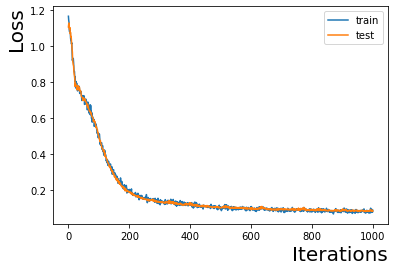

In [28]:
plt.plot(Loss_train,label='train')
plt.plot(Loss_test,label='test')
plt.xlabel('Iterations',fontsize=20,loc='right')
plt.ylabel('Loss',fontsize=20,loc='top')
plt.legend()

Based on this loss curve, I would 
1) Use a larger batch size
2) During the plateau I would start decreasing the learning rate :) 

**Will be important to evaluate whether the loss is lower or higher than the CNN / MLP models when using the same loss!!**

### Another check: Make some event dispalys

In [29]:
preds = model(X_norm_te, training=False).numpy() 

In [30]:
mu_y  = scalingDict[ 'mu_y']
std_y = scalingDict['std_y']

preds_unnormed = mu_y + std_y * preds
preds_unnormed[:,:,-1] = np.exp(preds_unnormed[:,:,-1])

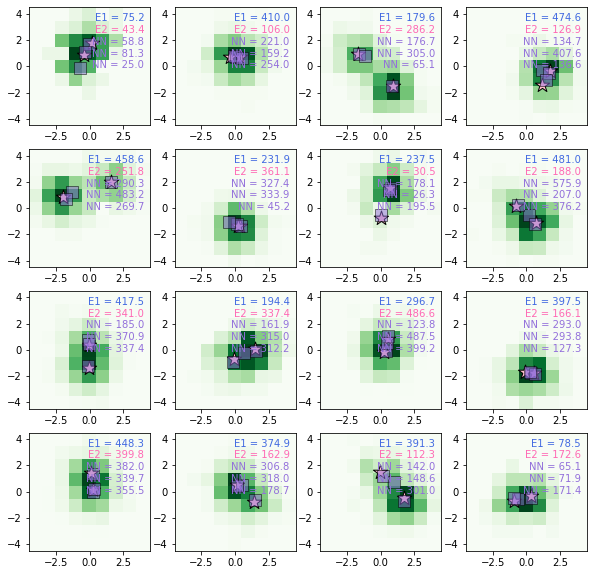

In [31]:
fig, ax = plt.subplots(4,4, figsize=(10,10))

start = 16
for k in range(start,32):
    
    i = (k-start) // 4
    j = k % 4
    
    axi = ax[i,j]
    
    # Draw the shower
    axi.hist2d(Xi,Yi, resolution, [(-4.5,4.5),(-4.5,4.5)],cmap='Greens', 
               weights=np.where(X_te[k].T.flatten()==0,0,X_te[k].T.flatten()))
    
    
    kwargs = {'transform':axi.transAxes,'ha':'right','va':'top'}
    
    y=.95
    dy = .1
    for i,(color,text_color) in enumerate(zip(['lightskyblue','pink'],['royalblue','hotpink'])):
    
        # Draw the truth labels on the plot
        axi.scatter(*Y_te[k,i,:2].T, 225, marker="*",color=color_i, edgecolor='k')
        axi.text(.95,y,f'E{i+1} = {Y_te[k,i,-1]:.1f}',color=text_color,**kwargs)
        y -= dy
        
        
    for i in range(num_slots):
        # Draw on the model predictions
        axi.scatter(*preds_unnormed[k,i,:2].T, 144, marker="s",color='mediumpurple', edgecolor='k',alpha=.5)
        
        axi.text(.95,y,f'NN = {preds_unnormed[k,i,-1]:.1f}',color='mediumpurple',**kwargs)
        y -= dy
         
plt.show()   

OK, not optimized, but I think the preprocessing tricks from the other nets might make a big difference here.

## Next step: Hungarian weighted loss

**Goal:** Get the Hungarian loss for

In [ ]:
y_p

In [ ]:
pairwise_cost = tf.losses.MSE(reduction=tf.keras.losses.Reduction.NONE)(
  tf.expand_dims(y, axis=-2), tf.expand_dims(x, axis=-3))
indices = np.array(
  list(map(scipy.optimize.linear_sum_assignment, pairwise_cost)))

transposed_indices = np.transpose(indices, axes=(0, 2, 1))

actual_costs = tf.gather_nd(
  pairwise_cost, transposed_indices, batch_dims=1)

return tf.reduce_mean(tf.reduce_sum(actual_costs, axis=1))

## Proposals for next steps

1. Use the CNN that worked best for photon construction (i.e, insert the CNN architecture here)
2. Scan over the hyperparameters